In [4]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import csv
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import plotly
import plotly.graph_objs as go
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.corpus import stopwords
import re
from nltk.tokenize import sent_tokenize, word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
# Function to parse date
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Read CSV while parsing the dates
opinion_df = pd.read_csv('all_opinions.csv', parse_dates=['date_filed'], date_parser=dateparse)

# Copy the main df
opinion_copy = opinion_df.copy()

# Get opinions in the past 50 years
above_1970 = opinion_copy[opinion_copy['date_filed'] > "1970-01-01"]

# Remove Justice Douglas given how his opinions is highly unusual
# Refer to https://www.thenation.com/article/archive/tragedy-william-o-douglas/
above_1970_no_douglas = above_1970[above_1970['author_name'] != 'Justice Douglas']

# Remove those texts with less than 3000 characters as these are recounting past opinions
# Refer to https://www.kaggle.com/gqfiddler/scotus-opinions description of the dataset
char_above3000_1970 = above_1970_no_douglas[above_1970_no_douglas['text'].str.len() > 3000]

# Drop values that are not relevant for our analysis
to_analyze = char_above3000_1970.drop(columns=['absolute_url', 'cluster', 'year_filed', 
                                      'scdb_id', 'date_filed', 'author_name', 'federal_cite_one',
                                       'scdb_decision_direction', 'scdb_votes_majority', 'scdb_votes_minority'])
# Check the new_df
to_analyze = to_analyze.reset_index(drop=True)
#to_analyze = to_analyze[:2000]

In [6]:
# Function to preprocess text

def clean(x):
    
    # Split the case name into array for individual capitalizing
    case_name_array = x['case_name'].split()
    
    # Iterate through the words to capitalize
    for i in range(len(case_name_array)):
        
        # If word not versus, capitalize it to remove later
        if case_name_array[i] != 'v.':
            case_name_array[i] = case_name_array[i].upper()
    
    # Join the case name array together
    case_name = ' '.join(case_name_array)
    
    # 1. Standardizing some punctuations
    tmp = x['text'].replace('’', "'")
#     tmp = tmp.replace('“', '"')
#     tmp = tmp.replace('”', '"')
    tmp = tmp.replace('–', "-")
    tmp = re.sub(r'([.]\s+){2,10}', '', tmp)
    tmp = tmp.replace('[', '')
    tmp = tmp.replace(']', '')
    
    # 2. Remove redundant words
    
    # A. (i) Remove Cite as: since these are words that keep appearing at the bottom of the transcript for citation
    tmp = re.sub(r'Cite as:(.*?)\((\d{4})\)', '', tmp)
    
    # A. (ii) Remove Opinion of Justice given it is a demarcation of the transcript
    tmp = re.sub(r'Opinion\s(.*?)\n', '', tmp)
    
    # B. Remove Case Name
    tmp = re.sub(f'''{case_name}''', '', tmp)
    
    #B. Remove See ... (As these are citations of previous cases to be used)
    # Three Cases
    # i) See case and citation
    see_pattern = re.compile(r"See(.*?)(\)\.|\)\;|\d\.)", re.DOTALL)
    tmp = re.sub(see_pattern, '', tmp)
    
    # (ii) Remove quotes i.e. Herring v. New York, 422 U.S. 853, 862 (1975)
#     tmp = re.sub(r'', '', tmp)

#     print(tmp)
    
    # 3. Remove unicode characters in text
    tmp = re.sub(r'[^\x00-\x7F]+', '', tmp)
    
    # 4. Remove breakline in text
    
    # A. Embedded in the string (-\\n)
    tmp = re.sub(r'-\n\s{1,}', '', tmp)
    tmp = re.sub(r'-\n', '', tmp) 
    
    # B. Remove long breaks
    tmp = re.sub(r'\n\s+', ' ', tmp)
    
    # C. Remove the remaining breaklines
    tmp = re.sub(r'\n', ' ', tmp)
    
    # 5. Remove Numbers that demarcate sections of opinions
    tmp = re.sub(r'\s\d{1,}\s{2,}', ' ', tmp)
    
    return tmp

# Instantiate the set of stopwords
stoplist = stopwords.words('english')
stoplist += ['u', 'state', 'court', 'id', 'amendment', 'respondent', 'appeal', 'case', 'may','could','would', 'c', 'v', 'u', 'one', 'see', 'even', 'issue', 'however', 'supra', 'clause', 'constitutional', 'jury', 'petitioner', 'j', 'requirement', 'ante', 'claim', 'standard', 'process', 'review', 'regulation', 'employee', 'judge', 'criminal', 'n', 'statutory', 'majority', 'individual', 'argument', 'benefit', 'judicial', 'policy', 'result', 'conduct', 'required', 'agency', 'school', 'officer', 'statement', 'violation', 'rather', 'particular', 'ibid', 'circumstance', 'support', 'second', 'protection', 'reasonable', 'party', 'counsel', 'basis', 'clear', 'plan', 'language', 'application', 'sentence', 'well', 'law', 'system', 'member', 'dissenting', 'principle', 'holding', 'need', 'mean', 'procedure', 'although', 'conclusion', 'based', 'private', 'app', 'defendant', 'due', 'practice', 'relief', 'respect', 'since', 'attorney', 'year', 'proceeding', 'prior', 'b', 'legislative', 'provision', 'crime', 'different', 'agreement', 'point', 'inc', 'civil', 'rule', 'provide', 'union', 'today', 'employer', 'purpose', 'way', 'legal', 'decision', 'course', 'child', 'activity', 'finding', 'offense', 'brief', 'statute', 'damage', 'history', 'hearing', 'relevant', 'simply', 'certain', 'conviction', 'ed', 'official', 'remedy', 'require', 'set', 'used', 'interpretation', 'word', 'information', 'police', 'term', 'provides', 'national', 'requires', 'class', 'intended', 'apply', 'concluded', 'death', 'interest', 'example', 'cost', 'place', 'le', 'work', 'hold', 'determination', 'exercise', 'burden', 'ii', 'indeed', 'like', 'say', 'granted', 'limitation', 'emphasis', 'consideration', 'test', 'concurring', 'find', 'take', 'concern', 'person', 'immunity', 'either', 'filed', 'discrimination', 'fact', 'give', 'iii', 'permit', 'three', 'program', 'liability', 'supp', 'meaning', 'petition', 'another', 'applied', 'search', 'report', 'limited', 'challenge', 'added', 'california', 'f', 'motion', 'exception', 'least', 'consider', 'substantial', 'intent', 'defense', 'appropriate', 'fee', 'reason', 'dissent', 'many', 'recognized', 'limit', 'injury', 'nothing', 'l']
stopwords_set = set(stoplist)

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(x):
    
    # 1. Lower case
    tmp = x.lower()
    
    # 2. Remove punctuations
    tmp = tmp.translate(str.maketrans('', '', string.punctuation))
    
    # 3. Tokenize the sentences
    tokens = word_tokenize(tmp)
    
    # 4. Remove stopwords
    no_stopwords = [word for word in tokens if word not in stopwords_set and word.isalpha()]
    
    # 5. Lemmatize
    lemma_text = ' '.join([lemmatizer.lemmatize(word) for word in no_stopwords])
    
    return lemma_text

to_analyze['cleaned_text'] = to_analyze.apply(lambda x : clean(x), axis=1)
to_analyze['preprocessed_text'] = to_analyze['cleaned_text'].apply(lambda x: preprocess(x))


In [7]:
from sklearn.feature_extraction import stop_words
stopList=(stop_words.ENGLISH_STOP_WORDS)
stopList = [stop.lower() for stop in stopList]
additional_stop_words = ['u', 'state', 'court', 'id', 'amendment', 'respondent', 'appeal', 'case', 'may','could','would', 'c', 'v', 'u', 'one', 'see', 'even', 'issue', 'however', 'supra', 'clause', 'constitutional', 'jury', 'petitioner', 'j', 'requirement', 'ante', 'claim', 'standard', 'process', 'review', 'regulation', 'employee', 'judge', 'criminal', 'n', 'statutory', 'majority', 'individual', 'argument', 'benefit', 'judicial', 'policy', 'result', 'conduct', 'required', 'agency', 'school', 'officer', 'statement', 'violation', 'rather', 'particular', 'ibid', 'circumstance', 'support', 'second', 'protection', 'reasonable', 'party', 'counsel', 'basis', 'clear', 'plan', 'language', 'application', 'sentence', 'well', 'law', 'system', 'member', 'dissenting', 'principle', 'holding', 'need', 'mean', 'procedure', 'although', 'conclusion', 'based', 'private', 'app', 'defendant', 'due', 'practice', 'relief', 'respect', 'since', 'attorney', 'year', 'proceeding', 'prior', 'b', 'legislative', 'provision', 'crime', 'different', 'agreement', 'point', 'inc', 'civil', 'rule', 'provide', 'union', 'today', 'employer', 'purpose', 'way', 'legal', 'decision', 'course', 'child', 'activity', 'finding', 'offense', 'brief', 'statute', 'damage', 'history', 'hearing', 'relevant', 'simply', 'certain', 'conviction', 'ed', 'official', 'remedy', 'require', 'set', 'used', 'interpretation', 'word', 'information', 'police', 'term', 'provides', 'national', 'requires', 'class', 'intended', 'apply', 'concluded', 'death', 'interest', 'example', 'cost', 'place', 'le', 'work', 'hold', 'determination', 'exercise', 'burden', 'ii', 'indeed', 'like', 'say', 'granted', 'limitation', 'emphasis', 'consideration', 'test', 'concurring', 'find', 'take', 'concern', 'person', 'immunity', 'either', 'filed', 'discrimination', 'fact', 'give', 'iii', 'permit', 'three', 'program', 'liability', 'supp', 'meaning', 'petition', 'another', 'applied', 'search', 'report', 'limited', 'challenge', 'added', 'california', 'f', 'motion', 'exception', 'least', 'consider', 'substantial', 'intent', 'defense', 'appropriate', 'fee', 'reason', 'dissent', 'many', 'recognized', 'limit', 'injury', 'nothing', 'l']
stopList += additional_stop_words

C:\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
#Cleaning fundmental and create tokens
def clean_text(text):
    #tokenization
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            tokens.append(word)
    filtered_tokens = []
    for token in tokens:
        token = token.lower()
        if re.search('[a-zA-Z]', token):
            if token not in stopList:
                filtered_tokens.append(token)   #punctuation, stop word and NER
    
    return filtered_tokens

In [9]:
#cleaning data with Lemma
def lemma_text(text):
    cleaned_text = clean_text(text)
    stemmer = PorterStemmer()
    stemmed_tokens = []
    #lemmatization and stemming
    for token in cleaned_text:
        stemmed_tokens.append(WordNetLemmatizer().lemmatize(token))
    return stemmed_tokens

In [10]:
reviews = to_analyze.preprocessed_text
lemmaList = reviews.apply(lemma_text)

In [11]:
#Sen token
def sent_2_doc(document):    
    clean_words = " ".join([sent for sent in document])
    return clean_words

In [12]:
lemmaDocList = [sent_2_doc(doc) for doc in lemmaList]

In [13]:
#Vectors
lemma_tfidf_vec = TfidfVectorizer(tokenizer=lemma_text)
lemma_tfidf_matrix = lemma_tfidf_vec.fit_transform(reviews)
lemma_terms = lemma_tfidf_vec.get_feature_names()

In [14]:
desc = to_analyze.preprocessed_text.values
vectorizer = TfidfVectorizer(tokenizer=lemma_text)
X3 = vectorizer.fit_transform(desc)
words3= vectorizer.get_feature_names()

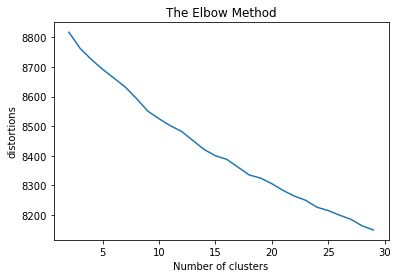

In [15]:
#Elbow
distortions = []
K = range(1,11)
for i in range(2,30):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X3)
    distortions.append(kmeans.inertia_)
plt.plot(range(2,30),distortions)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('distortions')
plt.savefig('./elbow_Kmeans.png')
plt.show()

In [16]:
NUM_CLUSTERS = 12 #Change this according to the elbow method

In [17]:
#K-means
lemma_km = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++', max_iter=50, n_init=20)
lemma_km.fit(lemma_tfidf_matrix)
lemma_clusters = lemma_km.labels_.tolist()

In [18]:
#create a dataframe df for only reviews. we will focus only on reviews for saving the output
df = pd.DataFrame({'Options':lemmaDocList}) 

In [19]:
#Storing Cluster number and labels for each comment
comment_cluster_df = pd.DataFrame(df)

order_centroids = lemma_km.cluster_centers_.argsort()[:, ::-1]
n_words_5=5
label_list=[]
words_list=[]
print(type(lemma_clusters))
for i in range(len(lemma_clusters)):
    topicWords = []
    #print(lemma_clusters[i])
    for ind in order_centroids[lemma_clusters[i], :n_words_5]:
        #print(' %s' % clean_terms[ind]),
        topicWords.append(lemma_terms[ind])
    #print(topicWords)
    label_list.append(str(lemma_clusters[i]))
    words_list.append(str(topicWords))
    
comment_cluster_df['freq_words'] = label_list
comment_cluster_df['comment_label'] = words_list
print('Saving to csv')
comment_cluster_df.to_csv('./clustering_output.csv', index=False)

    #clean_predictedTopic_5.append(topicWords)

<class 'list'>
Saving to csv


In [20]:
# Print Cluster Topics
unique_set=set(words_list)
#print(unique_set)
unique_list=list(unique_set)
for elem in unique_list:
        print(elem) 

['fourth', 'warrant', 'arrest', 'seizure', 'probable']
['board', 'vii', 'title', 'labor', 'alien']
['arbitration', 'contract', 'arbitrator', 'faa', 'arbitrate']
['habeas', 'prisoner', 'prison', 'inmate', 'federal']
['indian', 'tribe', 'tribal', 'reservation', 'land']
['tax', 'income', 'taxpayer', 'property', 'commerce']
['speech', 'religious', 'public', 'ordinance', 'religion']
['sentencing', 'juror', 'penalty', 'mitigating', 'capital']
['act', 'congress', 'united', 'federal', 'government']
['election', 'candidate', 'voter', 'district', 'voting']
['federal', 'action', 'jurisdiction', 'district', 'congress']
['trial', 'evidence', 'right', 'witness', 'testimony']


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

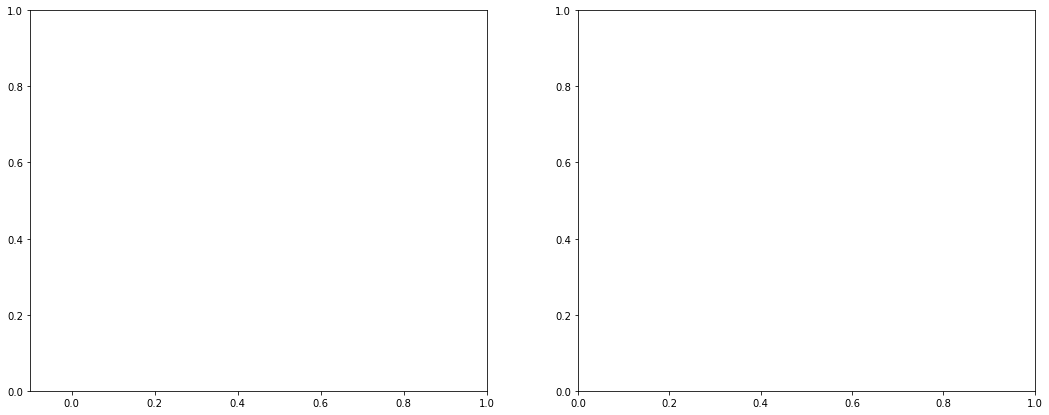

In [21]:
#Silhoutte Approach
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X3) + (n_clusters + 1) * 10])
    
    #Cluster
    lemma_S= KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200, n_init=20)
    cluster_labels = lemma_S.fit_predict(X3)
    
    silhouette_avg = silhouette_score(X3, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X3, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X3[:, 0], X3[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()